In [1]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from einops import rearrange
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
from typing import Any
import glob
import re
from datetime import datetime
import random
from collections import defaultdict
import numpy as np

import torch.nn.functional as torch_func
from torchvision.transforms.functional import rotate, affine, resize, center_crop
from PIL import Image
import cv2

random.seed(42)

In [2]:
import onnxruntime

In [3]:
from models.allcnn2d import AllCNN2D, AllCNN2D_Prod
from drawing.interactive import draw_image

# Global

In [4]:
DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"

# Paths

In [5]:
file_path: str = os.path.abspath(".")
root_path: str = os.path.join(file_path, os.pardir, os.pardir)
checkpoint_path: str = r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\checkpoints\Mongo_epoch17_trainacc0.9517_valacc0.99432_Tloss0.010203_Vloss0.002475_lr0.0007224.pkl"
model_name: str = "MongoCNN_Prod"


# Load Model

In [6]:
alphabet: list[str] = list('∀∃().0123456789:λμabcdefghijklmnopqrstuvwxyz')
len(alphabet)

44

In [7]:

cnn_model: nn.Module = AllCNN2D(
    **{
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, len(alphabet)), 
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.075,
        "verbose": True,
        "name_prefix": model_name,
    }
)


Layer (type:depth-idx)                   Output Shape              Param #
AllCNN2D                                 [1, 44]                   --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 64, 64]           160
│    │    └─Dropout2d: 3-2               [1, 16, 64, 64]           --
│    │    └─BatchNorm2d: 3-3             [1, 16, 64, 64]           32
│    │    └─LeakyReLU: 3-4               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-5                  [1, 16, 32, 32]           2,320
│    │    └─Dropout2d: 3-6               [1, 16, 32, 32]           --
│    │    └─BatchNorm2d: 3-7             [1, 16, 32, 32]           32
│    │    └─LeakyReLU: 3-8               [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-9                  [1, 32, 32, 32]           4,640
│    │  

In [8]:
cnn_model.load_state_dict(torch.load(checkpoint_path, weights_only=True))

<All keys matched successfully>

In [9]:

# Create a dummy input tensor
dummy_input = torch.randn(1, 1, 64, 64)  # Example input

# Define the ONNX file path
onnx_file_path = f"Mongo_LC_Prod.onnx"

# Export the model
torch.onnx.export(
    cnn_model.to(device=DEVICE),
    dummy_input.to(device=DEVICE),
    onnx_file_path,
    input_names=["input"],  # Name of the input layer
    output_names=["logits"],  # Names of the output layers
    dynamic_axes={"input": {0: "batch_size"}, "logits": {0: "batch_size"}},
    opset_version=11  # Specify the ONNX opset version
)

print(f"Model saved to {onnx_file_path}")

Model saved to Mongo_LC_Prod.onnx


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_ONNX_WRAPPER(nn.Module):
    alphabet: list[str] = list("∃().0123456789:λμabcdefghijklmnopqrstuvwxyz")

    model: nn.Module  # This should be set to your actual CNN model

    def __init__(self, cnn_model: nn.Module):
        super(CNN_ONNX_WRAPPER, self).__init__()
        self.model = cnn_model

    @staticmethod
    def preprocess_im(im: torch.Tensor, threshold: float, image_dims: tuple, pad: int) -> torch.Tensor:
        # Apply the thresholding
        image = torch.where(
            im.squeeze() > threshold, 
            torch.tensor(1.0), 
            torch.tensor(0.0)
        )

        # Optionally, flip the image based on the top-left corner pixel value
        # Compare the value directly without using .item()
        if image[0, 0] > 0.5:  # Tensor comparison (element-wise)
            image = 1.0 - image

        # Crop around black pixels (foreground)
        mask = image > 0.5  # Assume the foreground is black
        coords = torch.nonzero(mask)

        if coords.shape[0] > 0:
            # Get min and max coordinates directly as tensors, no need for .item()
            min_coords = coords.min(dim=0)[0]  # Get the min values
            max_coords = coords.max(dim=0)[0]  # Get the max values
            
            # Use tensor indexing for cropping
            x_min, y_min = min_coords[0], min_coords[1]
            x_max, y_max = max_coords[0], max_coords[1]
            
            # Crop the image based on coordinates
            image = image[x_min:x_max + 1, y_min:y_max + 1]

        # Resize the image using interpolate (ONNX-compatible)
        image = F.interpolate(image.unsqueeze(0).unsqueeze(0), size=[d - pad * 2 for d in image_dims])

        # Apply threshold again after resizing
        image = (image > threshold).to(torch.float32)

        # Pad the image
        image = F.pad(image, (pad, pad, pad, pad), value=0.0)

        return image

    @staticmethod
    def softmax(x: torch.Tensor) -> torch.Tensor:
        # Softmax on the logits
        return torch.nn.functional.softmax(x, dim=1)

    def forward(self, im: torch.Tensor) -> torch.Tensor:
        # Preprocess the input image
        im = self.preprocess_im(im, 0.5, (64, 64), 1)

        # Debugging step: Check tensor shape before model inference
        print(f"Processed image shape: {im.shape}")

        # Forward pass through the model
        logits = self.model(im)  # Add batch dimension and pass through the model

        # Debugging step: Check the shape of logits
        print(f"Logits shape: {logits.shape}")

        # Apply softmax to get the percentages
        percentages = self.softmax(logits)

        return percentages


# Assuming cnn_model is defined somewhere (e.g., a CNN model architecture)

cnn = CNN_ONNX_WRAPPER(cnn_model)

# Create a dummy input tensor
dummy_input = torch.randn(1, 1, 64, 64)  # Example input with the shape [batch_size, channels, height, width]

# Define the ONNX file path
onnx_file_path = "Lake_FINAL_Prod.onnx"

# Export the model
torch.onnx.export(
    cnn.eval(),
    dummy_input,
    onnx_file_path,
    input_names=["input"],  # Name of the input layer
    output_names=["prob"],  # Names of the output layers
    dynamic_axes={"input": {0: "batch_size", 2: "height", 3: "width"}, "prob": {0: "batch_size"}},
    opset_version=12  # Specify the ONNX opset version
)

print(f"Model saved to {onnx_file_path}")




# Load Onnx

In [10]:
import onnxruntime
import numpy as np
import os
from PIL import Image

In [ ]:
onnx_file_path = f"Lake_FINAL_Prod.onnx"

# Load the ONNX model
model_path = onnx_file_path

# Define the execution providers without TensorRT
providers = ['CPUExecutionProvider']

# Create the InferenceSession with the explicit providers
session = onnxruntime.InferenceSession(model_path, providers=providers)

# Prepare the input image
input_image = np.random.random(
    (
        1,  # batch: stack as many images as you like here
        1,  # channels: needs to be 1 (grayscale), pixels are 1.0 or 0.0
        64, # height: fixed to 64 pixels for now
        64  # width: fixed to 64 pixels for now
    )
).astype(np.float32)





In [ ]:
inputs: list[onnxruntime.NodeArg] = session.get_inputs()
outputs: list[onnxruntime.NodeArg] = session.get_outputs()

input_name: list[str] = inputs[0].name
output_names: list[str] = [out.name for out in outputs]

test_im_path: str = r"test_im.png"
test_im: Image.Image = Image.open(test_im_path).convert("L")
test_im_np: np.ndarray = np.asarray(test_im).astype(np.float32)

c_prob = cnn.eval().forward(torch.tensor(test_im_np))
prob = session.run(
    output_names, 
    {input_name: np.expand_dims(np.expand_dims(test_im_np, 0), 0)}
)

Processed image shape: torch.Size([1, 1, 64, 64])
Logits shape: torch.Size([1, 43])
Top indices shape: torch.Size([1, 43])


In [ ]:
list(zip([x for x in c_prob], [x for x in prob]))
# Run inference


[(tensor([[9.9999e-01, 5.2548e-06, 1.7248e-06, 8.1988e-07, 7.9782e-07, 5.8198e-07,
           3.0758e-07, 2.0259e-07, 1.6081e-07, 1.2946e-07, 2.3220e-08, 2.1835e-08,
           1.7244e-08, 1.7012e-08, 1.5099e-08, 1.0663e-08, 1.0223e-08, 2.6446e-09,
           2.5364e-09, 2.4631e-09, 2.3556e-09, 1.3106e-09, 9.8690e-10, 8.5152e-10,
           1.5691e-10, 8.2225e-11, 5.7212e-11, 4.9990e-11, 3.8997e-11, 1.2193e-11,
           2.4857e-12, 9.5809e-13, 9.4636e-13, 5.4760e-13, 1.8145e-13, 1.3831e-13,
           1.3262e-13, 3.5077e-14, 2.8431e-16, 1.8610e-16, 1.0641e-16, 6.3491e-17,
           1.4506e-17]], device='cuda:0', grad_fn=<GatherBackward0>),
  array([[9.9998999e-01, 5.2570049e-06, 1.7245728e-06, 8.1932870e-07,
          7.9734730e-07, 5.8144116e-07, 3.0757428e-07, 2.0254525e-07,
          1.6080422e-07, 1.2947180e-07, 2.3234454e-08, 2.1837661e-08,
          1.7260124e-08, 1.7012930e-08, 1.5071729e-08, 1.0674785e-08,
          1.0232568e-08, 2.6464866e-09, 2.5363978e-09, 2.4632330e-09,

# Class

# Inference

In [ ]:
import torch
import numpy as np
from PIL import Image
from torchvision.transforms import functional as F

def preprocess_im(im: str, threshold: float, image_dims: tuple, pad: int) -> np.ndarray:
    # Load the image
    image = Image.open(im)
    
    # Convert to grayscale (if not already)
    image = image.convert("L")
    
    # Convert the image to a tensor
    image = F.to_tensor(image).squeeze()
    
    # Thresholding the image
    image = torch.where(image > threshold, torch.tensor(1.0), torch.tensor(0.0))

    
    if image[0, 0] > 0.5:
        image = 1.0 - image
    
    # Crop the image around the black pixels (foreground)
    mask = image > 0.5  # Assuming foreground is black (0) and background is white (1)
    coords = torch.nonzero(mask)
    
    if coords.shape[0] > 0:
        # Get min and max coordinates
        min_coords = coords.min(dim=0)[0]  # Getting the min values
        max_coords = coords.max(dim=0)[0]  # Getting the max values
        
        x_min, y_min = min_coords[0].item(), min_coords[1].item()  # Convert tensor to scalar
        x_max, y_max = max_coords[0].item(), max_coords[1].item()  # Convert tensor to scalar
        
        # Crop the image based on coordinates
        image = image[x_min:x_max + 1, y_min:y_max + 1]
    
    # Resize to the desired dimensions
    image = F.resize(image.unsqueeze(0), [d - pad * 2 for d in image_dims])
    
    # Threshold again after resize
    image = (image > threshold).type(torch.uint8).type(torch.float32)

    # Pad the image
    image = F.pad(image, (pad, pad, pad, pad), fill=0.0)

    # Convert to NumPy array
    image = image.squeeze().cpu().numpy()  # Remove the batch dimension and convert to NumPy

    return image


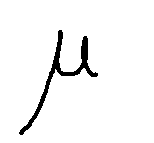

In [ ]:
test_im_path: str = r"test_im.png"
test_im: Image.Image = Image.open(test_im_path).convert("L")
test_im

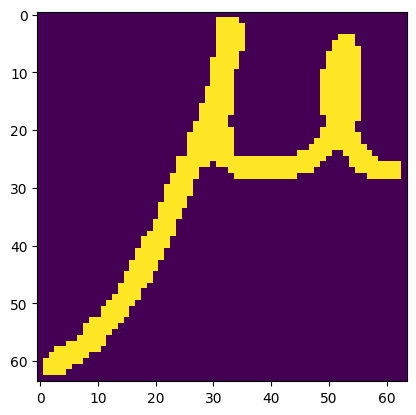

In [ ]:
test_im_np = preprocess_im(test_im_path, 0.1, (64, 64), 1)

plt.imshow(test_im_np)
plt.show()

(array([9.94052410e-01, 1.23858731e-03, 9.81083489e-04, 6.86358311e-04,
        6.23539032e-04, 6.17766578e-04, 6.12980337e-04, 4.79297625e-04,
        1.40747419e-04, 1.03887825e-04, 1.03488579e-04, 1.00947203e-04,
        9.20660677e-05, 8.27235781e-05, 1.91916297e-05, 1.06729467e-05,
        9.47296121e-06, 8.12046710e-06, 7.98343717e-06, 7.91991897e-06,
        4.30528098e-06, 3.55534780e-06, 3.19691048e-06, 2.17775141e-06,
        1.96297742e-06, 1.89501952e-06, 1.31547233e-06, 6.72157057e-07,
        6.70021336e-07, 4.55316723e-07, 1.70466848e-07, 1.66958785e-07,
        6.93960942e-08, 3.81598682e-08, 3.45308315e-08, 2.14136531e-09,
        1.18820531e-09, 9.17822873e-10, 1.36637798e-10, 5.52658717e-11,
        5.39423055e-11, 2.60328044e-11, 1.79959415e-11], dtype=float32),
 array([ 956,  101,  116,  107,  122,   98,  108,  120,  104,   49,  102,
         955,  112,  121,  100,   97,  117,   58,  113,  114,   40,  110,
         118,  105,   54,  119,   52,   50,   55,  109,   4

In [ ]:
test_im_np.shape

(64, 64)

In [ ]:

softmax: np.ndarray
softmax_ordered: np.ndarray
logits: np.ndarray

logits = session.run(
    output_names, 
    {input_name: np.expand_dims(np.expand_dims(test_im_np, 0), 0)}
)[0]

# logits.shape is shape (batch, character) for all character labels
# softmax.shape is shape (batch, character) for all character labels
# softmax_ordered is shape (batch, character, [label index, label prob, unicode character value])

# character dim is 44 (there are 44 character labels)
# label index is from 0 to 44 (corresponding to each ordered label index)
# label prob is a softmaxed probability for this label prediction
# unicode character value is the unicode character for this prediction



43

In [ ]:
index = np.argmax(softmax(logits.squeeze()))
alphabet[index]

'μ'

In [ ]:

softmax(logits)

array([[5.30846650e-04, 1.68099464e-03, 1.37032261e-02, 1.18300821e-04,
        5.17544569e-03, 1.18788116e-01, 7.00770020e-02, 2.72251527e-05,
        5.65034361e-06, 2.70747951e-05, 7.02182706e-06, 1.98335965e-05,
        2.47772950e-05, 2.26152275e-04, 2.94749648e-03, 5.39878034e-04,
        1.65653706e-01, 1.00289382e-01, 2.63870694e-03, 1.34053471e-05,
        6.00268249e-04, 2.87390407e-03, 3.22919041e-05, 2.28433162e-02,
        7.75476918e-04, 1.12298233e-06, 1.69513543e-04, 2.67672760e-07,
        3.25475936e-03, 7.96237418e-06, 1.93356220e-02, 5.77072799e-03,
        3.84508690e-04, 9.18507576e-03, 4.11047113e-05, 5.12989820e-04,
        1.17080397e-07, 9.30333436e-02, 1.01616504e-02, 3.10798088e-04,
        8.07399279e-04, 3.47387671e-01, 1.58225430e-05]], dtype=float32)

In [ ]:


top_character_probs: list[list[float]] = softmax_ordered[:, :, 1].tolist()

top_characters: list[list[str]] = [
    [
        chr(int(softmax_ordered[batch_i, i, 2])) 
        for i in range(softmax_ordered.shape[1])
    ] for batch_i in 
    range(softmax_ordered.shape[0])
]


NameError: name 'softmax_ordered' is not defined

# Hello World

In [ ]:
class TextReShitter(nn.Module):
    
    def __init__(self, alphabet: list[str], text: str):
        
        super(TextReShitter, self).__init__()
        
        self.alphabet: list[str] = alphabet
        self.text: str = text
        
        self.logits: list[torch.Tensor] = []
        
        for c in self.text:
            c_index: int = self.alphabet.index(c)
            
            char_logits: torch.Tensor = torch.rand((len(alphabet),))
            char_logits[c_index] += 2
            char_logits *= (torch.rand(1)+0.1)

            self.logits.append(char_logits)

        self.logits_tensor: torch.Tensor = torch.stack(self.logits, dim=0)
        
        self.logits_tensor = self.logits_tensor.unsqueeze(0) # batch, chars, logit
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        self.logits_tensor = self.logits_tensor + x.sum() * 0.0  

        softmax = torch.softmax(self.logits_tensor, dim=-1)
        
        # Create indices for the first dimension (char_prob_i)
        char_prob_indices = torch.arange(softmax.size(-1), device=softmax.device).reshape(1, 1, -1, 1)
        
        # Create indices for the third dimension (ord(self.alphabet[char_prob_i]))
        alphabet_indices = torch.tensor([ord(c) for c in self.alphabet], device=softmax.device).reshape(1, 1, -1, 1)
        
        # Expand dimensions to match softmax shape
        char_prob_indices = char_prob_indices.expand(*softmax.shape, 1)
        alphabet_indices = alphabet_indices.expand(*softmax.shape, 1)
        
        # Concatenate along the last dimension
        softmax_ordered = torch.cat([char_prob_indices, softmax.unsqueeze(-1), alphabet_indices], dim=-1)
        
        # Sort along the probability dimension (dim=-2)
        sorting_indices = softmax_ordered[..., 1].argsort(dim=-1, descending=True)
        sorted_tensor = torch.gather(softmax_ordered, -2, sorting_indices.unsqueeze(-1).expand(-1, -1, -1, 3))
        
        x = x * 0.5
        
        unicodes: torch.Tensor = sorted_tensor[0, :, :, 2]
        probs: torch.Tensor = sorted_tensor[0, :, :, 1]
        
        unicodes = unicodes.to(dtype=torch.int)
        
        return unicodes, probs 
        
        
        

In [ ]:
hello_world_model = TextReShitter(alphabet, "hello.world")

hello_world_model.forward(torch.zeros(1, 1, 1, 1))


(tensor([[104,  54,  57,  98, 121, 113, 111, 105,  50, 118,  55, 119,  51,  43,
          116,  40, 108, 117, 247,  97, 215, 115, 122,  99,  52,  45, 110,  53,
           41, 112,  48,  46, 103, 100,  49, 109,  56, 120, 955, 106, 114, 107,
          101, 102],
         [101, 103,  57, 955,  53,  97, 100, 215,  51, 114, 119,  40, 109,  48,
          108,  54,  46,  50, 102, 121, 247, 120, 116, 115, 122,  99,  55, 104,
           98,  41, 107, 110, 106, 113, 118, 105,  43, 117,  45, 111,  52, 112,
           56,  49],
         [108,  51,  50, 103, 105, 100, 113, 116, 247, 109, 119,  99,  45, 104,
          121, 118,  46,  43,  98,  55, 120,  52, 955,  54,  41,  49,  57, 115,
          102,  48,  53, 112, 101,  40, 114, 111, 215, 122,  56, 106,  97, 117,
          107, 110],
         [108,  45, 116,  99,  54,  48, 102, 121, 106,  51,  98,  56,  46, 215,
          115, 247, 101,  40,  52,  49,  57, 104, 111, 120, 955,  55, 110, 122,
          119, 113, 100,  41, 109,  50,  97, 117,  43, 11

# ONNX: Save Hello World

In [ ]:
# Create a dummy input tensor
dummy_input = torch.randn(1, 1, 100, 100)  # Example input

# Define the ONNX file path
onnx_file_path = "hello_world.onnx"

# Export the model
torch.onnx.export(
    hello_world_model,
    dummy_input,
    onnx_file_path,
    input_names=["input"],  # Name of the input layer
    output_names=["unicode", "probability"],  # Names of the output layers
    dynamic_axes={"input": {2: "height", 3: "width"}},
    opset_version=11  # Specify the ONNX opset version
)

print(f"Model saved to {onnx_file_path}")

Model saved to hello_world.onnx


C:\Users\Leon\AppData\Local\Temp\ipykernel_1824\427549207.py:35: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  alphabet_indices = torch.tensor([ord(c) for c in self.alphabet], device=softmax.device).reshape(1, 1, -1, 1)


# Load Hello World Onnx

In [ ]:

# Load the ONNX model
model_path = "hello_world.onnx"
session = onnxruntime.InferenceSession(model_path)

input_image = np.random.random(
    (
        1,  # batch: stack as many images as you like here
        1,  # channels: needs to be 1 (grayscale), pixels are 1.0 or 0.0
        2,  # height: fixed to 1 for now
        1   # width: fixed to 1 for now
    )
).astype(np.float32)

# Run inference
inputs: list[onnxruntime.NodeArg] = session.get_inputs()
outputs: list[onnxruntime.NodeArg] = session.get_outputs()

input_name: str = inputs[0].name
output_names: list[str] = [out.name for out in outputs]
softmax: np.ndarray
softmax_ordered: np.ndarray
logits: np.ndarray

unicodes, probs = session.run(
    output_names, 
    {input_name: input_image}
)

list(map(chr, unicodes[:, 0].tolist()))



['h', 'e', 'l', 'l', 'o', '.', 'w', 'o', 'r', 'l', 'd']

# Create CNN Production

In [11]:


class KrudModel(nn.Module):
    
    def __init__(
        self, 
        alphabet: list[str], 
        target_width: int = 64, 
        target_height: int = 64, 
        padding: int = 1,
        model: torch.nn.Module = None
    ):
        
        super(KrudModel, self).__init__()
        
        self.alphabet: list[str] = alphabet
        self.alphabet_float: torch.Tensor = torch.tensor([ord(a) for a in self.alphabet], dtype=torch.float32) 
        self.target_width: int = target_width
        self.target_height: int = target_height
        self.padding: int = padding
        self._unpadded_dims: tuple[int] = (
            self.target_height-self.padding*2,
            self.target_width-self.padding*2
        )
        self.model: torch.nn.Module = model.eval()
    
        
    def preprocess_image(
        self, 
        im: torch.Tensor
    ) -> torch.Tensor:
        """
        Preprocesses the input image by cropping, resizing, binarizing, and padding it.

        Args:
            im (torch.Tensor): Input image tensor of shape (C, H, W) or (B, C, H, W).

        Returns:
            torch.Tensor: Preprocessed image tensor.
        """
        # Step 1: Binarize the image (foreground = 0, background = 1)
        mask = im > 0.5

        # Step 2: Find bounding box coordinates of the foreground
        coords = torch.nonzero(mask)  # Get coordinates of non-zero (foreground) pixels

        # Step 3: Check if there are any foreground pixels (traceable)
        has_foreground = torch.any(mask)

        # Step 4: Compute min and max coordinates for cropping (if foreground exists)
        min_coords = torch.where(
            has_foreground,
            coords.min(dim=0)[0],
            torch.tensor([0, 0, 0, 0], device=im.device)  # Default value if no foreground
        )
        max_coords = torch.where(
            has_foreground,
            coords.max(dim=0)[0],
            torch.tensor([0, 0, im.size(2) - 1, im.size(3) - 1], device=im.device)  # Default value if no foreground
        )

        # Step 5: Extract min and max coordinates for height and width (assuming input is 4D: B, C, H, W)
        min_x, min_y = min_coords[2], min_coords[3]
        max_x, max_y = max_coords[2], max_coords[3]

        # Step 6: Crop the image (use slicing, which is traceable)
        im = im[:, :, min_x:max_x + 1, min_y:max_y + 1]

        # Step 7: Resize the image to the desired dimensions
        im = torch_func.interpolate(
            im, 
            size=self._unpadded_dims, 
            mode="bilinear", 
            align_corners=False
        )

        # Step 8: Binarize the image again (optional, depending on your use case)
        im = (im > 0.5).type(torch.uint8).type(torch.float32)

        # Step 9: Pad the image
        im = torch_func.pad(
            im,
            (self.padding, self.padding, self.padding, self.padding),
            mode='constant',
            value=0.0
        )

        return im
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.preprocess_image(x)
        
        #plt.imshow(x.squeeze(), cmap="gray")
        #plt.show()
        
        y_hat: torch.Tensor = self.model(x)
        y_hat = y_hat.squeeze().squeeze()
        
        softmax = torch.softmax(y_hat, dim=-1)
        
        stacked = torch.stack([self.alphabet_float, softmax], dim=1)
        sorted_indices = torch.argsort(stacked[:, 1], descending=True)
        sorted_tensor = stacked[sorted_indices]

        unicodes: torch.Tensor = sorted_tensor[:, 0]
        probabilities: torch.Tensor = sorted_tensor[:, 1]

        unicodes = unicodes.to(dtype=torch.int)
        probabilities = probabilities.detach()

        return unicodes.unsqueeze(0), probabilities.unsqueeze(0)
        
        
       


cnn_sara

In [ ]:

alphabet: list[str] = list('∀∃().0123456789:λμabcdefghijklmnopqrstuvwxyz')

checkpoint_path: str = r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\checkpoints\Mongo_epoch17_trainacc0.9517_valacc0.99432_Tloss0.010203_Vloss0.002475_lr0.0007224.pkl"
model_name: str = "MongoCNN_Prod"

cnn_model: nn.Module = AllCNN2D(
    **{
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, len(alphabet)), 
        "expected_input_size": (64, 64),
        "device": "cpu",
        "conv_dropout": 0.075,
        "verbose": True,
        "name_prefix": model_name,
    }
).eval()

cnn_model.load_state_dict(torch.load(checkpoint_path, weights_only=True))

krud_model: KrudModel = KrudModel(
    alphabet,
    model=cnn_model
)

dummy_input = torch.randn(1, 1, 64, 64)  # Example input

krud_model.forward(dummy_input)

# Define the ONNX file path
onnx_file_path = "CNN_SARA_LC.onnx"

# Export the model
torch.onnx.export(
    krud_model,
    dummy_input,
    onnx_file_path,
    input_names=["input"],  # Name of the input layer
    output_names=["unicode", "probability"],  # Names of the output layers
    dynamic_axes={"input": {2: "height", 3: "width"}, "unicode": {0: "batch"}},
    opset_version=11  # Specify the ONNX opset version
)

print(f"Model saved to {onnx_file_path}")

Layer (type:depth-idx)                   Output Shape              Param #
AllCNN2D                                 [1, 44]                   --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 64, 64]           160
│    │    └─Dropout2d: 3-2               [1, 16, 64, 64]           --
│    │    └─BatchNorm2d: 3-3             [1, 16, 64, 64]           32
│    │    └─LeakyReLU: 3-4               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-5                  [1, 16, 32, 32]           2,320
│    │    └─Dropout2d: 3-6               [1, 16, 32, 32]           --
│    │    └─BatchNorm2d: 3-7             [1, 16, 32, 32]           32
│    │    └─LeakyReLU: 3-8               [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-9                  [1, 32, 32, 32]           4,640
│    │  

C:\Users\Leon\AppData\Local\Temp\ipykernel_18944\1877883219.py:52: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  torch.tensor([0, 0, 0, 0], device=im.device)  # Default value if no foreground
C:\Users\Leon\AppData\Local\Temp\ipykernel_18944\1877883219.py:57: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  torch.tensor([0, 0, im.size(2) - 1, im.size(3) - 1], device=im.device)  # Default value if no foreground
c:\Users\Leon\AppData\Local\Programs\Python\Python310\lib\site-packages\

Model saved to CNN_SARA_LC.onnx


In [ ]:
model_path = onnx_file_path
session = onnxruntime.InferenceSession(model_path)

input_image = np.random.random(
    (
        1,  # batch: stack as many images as you like here
        1,  # channels: needs to be 1 (grayscale), pixels are 1.0 or 0.0
        64,  # height: fixed to 1 for now
        64   # width: fixed to 1 for now
    )
).astype(np.float32)

# Run inference
inputs: list[onnxruntime.NodeArg] = session.get_inputs()
outputs: list[onnxruntime.NodeArg] = session.get_outputs()

input_name: str = inputs[0].name
output_names: list[str] = [out.name for out in outputs]
softmax: np.ndarray
softmax_ordered: np.ndarray
logits: np.ndarray

unicodes, probs = session.run(
    output_names, 
    {input_name: input_image}
)

unicodes[0, :3]

(1, 44)

cnn_py

In [31]:

alphabet = list('!"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~')

checkpoint_path: str = r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\checkpoints\z_ApplePie_epoch185_trainacc0.71586_valacc0.74578_Tloss0.063201_Vloss0.060233_lr0.0001673200819949859.pkl"
model_name: str = "MongoCNN_Prod"

cnn_model: nn.Module = AllCNN2D(
    **{
        "conv_features": (1, 16, 32, 32, 32),
        "fully_connected_features": (128, len(alphabet)),
        "expected_input_size": (64, 64),
        "device": "cpu",
        "conv_dropout": 0.15,
        "verbose": True,
        "name_prefix": "CNN_py_Apple",
        "checkpoint_path": checkpoint_path
    }
).eval()

cnn_model.load_state_dict(torch.load(checkpoint_path, weights_only=True))

krud_model: KrudModel = KrudModel(
    alphabet,
    model=cnn_model
)

dummy_input = torch.randn(1, 1, 64, 64)  # Example input

# Define the ONNX file path
onnx_file_path = "CNN_APPLE_PY.onnx"

# Export the model
torch.onnx.export(
    krud_model,
    dummy_input,
    onnx_file_path,
    input_names=["input"],  # Name of the input layer
    output_names=["unicode", "probability"],  # Names of the output layers
    dynamic_axes={"input": {2: "height", 3: "width"}},
    opset_version=11  # Specify the ONNX opset version
)

print(f"Model saved to {onnx_file_path}")


Loaded: encoder_conv_blocks.0.0.weight
Loaded: encoder_conv_blocks.0.0.bias
Loaded: encoder_conv_blocks.0.2.weight
Loaded: encoder_conv_blocks.0.2.bias
Loaded: encoder_conv_blocks.0.2.running_mean
Loaded: encoder_conv_blocks.0.2.running_var
Loaded: encoder_conv_blocks.0.2.num_batches_tracked
Loaded: encoder_conv_blocks.0.4.weight
Loaded: encoder_conv_blocks.0.4.bias
Loaded: encoder_conv_blocks.0.6.weight
Loaded: encoder_conv_blocks.0.6.bias
Loaded: encoder_conv_blocks.0.6.running_mean
Loaded: encoder_conv_blocks.0.6.running_var
Loaded: encoder_conv_blocks.0.6.num_batches_tracked
Loaded: encoder_conv_blocks.1.0.weight
Loaded: encoder_conv_blocks.1.0.bias
Loaded: encoder_conv_blocks.1.2.weight
Loaded: encoder_conv_blocks.1.2.bias
Loaded: encoder_conv_blocks.1.2.running_mean
Loaded: encoder_conv_blocks.1.2.running_var
Loaded: encoder_conv_blocks.1.2.num_batches_tracked
Loaded: encoder_conv_blocks.1.4.weight
Loaded: encoder_conv_blocks.1.4.bias
Loaded: encoder_conv_blocks.1.6.weight
Loaded

C:\Users\Leon\AppData\Local\Temp\ipykernel_28708\77278072.py:52: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  torch.tensor([0, 0, 0, 0], device=im.device)  # Default value if no foreground
C:\Users\Leon\AppData\Local\Temp\ipykernel_28708\77278072.py:57: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  torch.tensor([0, 0, im.size(2) - 1, im.size(3) - 1], device=im.device)  # Default value if no foreground
c:\Users\Leon\AppData\Local\Programs\Python\Python310\lib\site-packages\torc

Model saved to CNN_APPLE_PY.onnx


cnn_apl

In [15]:

alphabet: list[str] = list('!"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~£¨¯´·×÷←↑→↓∆∇∊∘√∣∧∨∩∪≠≡≢≤≥⊂⊃⊆⊇⊖⊢⊣⊤⊥⋄⌈⌊⌶⌷⌸⌹⌺⌽⌿⍀⍉⍋⍎⍒⍕⍙⍛⍝⍞⍟⍠⍢⍣⍤⍥⍨⍪⍫⍬⍱⍲⍳⍴⍵⍷⍸⍺⎕○')
alphabet = alphabet + [" "] * (256 - len(alphabet))

checkpoint_path: str = r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\checkpoints\20250421_153213__BEST_APL_MODEL_V5__Epoch13_tLoss1.75856_tL153.07858_tMSE38.59373_tAcc0.57354_vLoss1.04812_vL154.07807_vMSE41.83569_vAcc0.70611.pt"
model_name: str = "APL_Prod_Best"

cnn_model: nn.Module = AllCNN2D(
    **{
        "conv_features": (1, 16, 32, 32, 32),
        "fully_connected_features": (256, 256),
        "expected_input_size": (64, 64),
        "device": "cpu",
        "conv_dropout": 0.05,
        "verbose": True,
        "name_prefix": model_name,
        "frozen_layer_prefixes": [],
    }
).eval()


cnn_model.load_state_dict(torch.load(checkpoint_path, weights_only=True))

krud_model: KrudModel = KrudModel(
    alphabet,
    model=cnn_model
)

dummy_input = torch.randn(1, 1, 64, 64)  # Example input

krud_model.forward(dummy_input)

# Define the ONNX file path
onnx_file_path = "CNN_APL_BEST_done.onnx"

# Export the model
torch.onnx.export(
    krud_model,
    dummy_input,
    onnx_file_path,
    input_names=["input"],  # Name of the input layer
    output_names=["unicode", "probability"],  # Names of the output layers
    dynamic_axes={"input": {2: "height", 3: "width"}, "unicode": {0: "batch"}},
    opset_version=11  # Specify the ONNX opset version
)

print(f"Model saved to {onnx_file_path}")

Layer (type:depth-idx)                   Output Shape              Param #
AllCNN2D                                 [1, 256]                  --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 64, 64]           160
│    │    └─Dropout2d: 3-2               [1, 16, 64, 64]           --
│    │    └─BatchNorm2d: 3-3             [1, 16, 64, 64]           32
│    │    └─LeakyReLU: 3-4               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-5                  [1, 16, 32, 32]           2,320
│    │    └─Dropout2d: 3-6               [1, 16, 32, 32]           --
│    │    └─BatchNorm2d: 3-7             [1, 16, 32, 32]           32
│    │    └─LeakyReLU: 3-8               [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-9                  [1, 32, 32, 32]           4,640
│    │  

C:\Users\Leon\AppData\Local\Temp\ipykernel_25308\1877883219.py:52: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  torch.tensor([0, 0, 0, 0], device=im.device)  # Default value if no foreground
C:\Users\Leon\AppData\Local\Temp\ipykernel_25308\1877883219.py:57: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  torch.tensor([0, 0, im.size(2) - 1, im.size(3) - 1], device=im.device)  # Default value if no foreground


In [ ]:

alphabet: list[str] = list('!"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~£¨¯´·×÷←↑→↓∆∇∊∘√∣∧∨∩∪≠≡≢≤≥⊂⊃⊆⊇⊖⊢⊣⊤⊥⋄⌈⌊⌶⌷⌸⌹⌺⌽⌿⍀⍉⍋⍎⍒⍕⍙⍛⍝⍞⍟⍠⍢⍣⍤⍥⍨⍪⍫⍬⍱⍲⍳⍴⍵⍷⍸⍺⎕○')
alphabet = alphabet + [" "] * (256 - len(alphabet))

checkpoint_path: str = r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\checkpoints\20250421_153213__BEST_APL_MODEL_V5__Epoch13_tLoss1.75856_tL153.07858_tMSE38.59373_tAcc0.57354_vLoss1.04812_vL154.07807_vMSE41.83569_vAcc0.70611.pt"
model_name: str = "APL_Prod_Best"

cnn_model: nn.Module = AllCNN2D(
    **{
        "conv_features": (1, 16, 32, 32, 32),
        "fully_connected_features": (256, 256),
        "expected_input_size": (64, 64),
        "device": "cpu",
        "conv_dropout": 0.05,
        "verbose": True,
        "name_prefix": model_name,
        "frozen_layer_prefixes": [],
    }
).eval()


cnn_model.load_state_dict(torch.load(checkpoint_path, weights_only=True))

krud_model: KrudModel = KrudModel(
    alphabet,
    model=cnn_model
)

dummy_input = torch.randn(1, 1, 64, 64)  # Example input

krud_model.forward(dummy_input)

# Define the ONNX file path
onnx_file_path = "CNN_APL_BEST_done.onnx"

# Export the model
torch.onnx.export(
    krud_model,
    dummy_input,
    onnx_file_path,
    input_names=["input"],  # Name of the input layer
    output_names=["unicode", "probability"],  # Names of the output layers
    dynamic_axes={"input": {2: "height", 3: "width"}, "unicode": {0: "batch"}},
    opset_version=11  # Specify the ONNX opset version
)

print(f"Model saved to {onnx_file_path}")

In [ ]:

cnn_onnx

In [16]:
dataset_dirpath: str = r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\data\apl_lora"
for im_filename in os.listdir(dataset_dirpath):
    fullpath: str = os.path.join(dataset_dirpath, im_filename)

    im = np.asarray(Image.open(fullpath))
    
    im = (im[:, :, 3] > 0.5).astype(np.uint8).astype(np.float32)
    
    im_tensor = torch.tensor(im, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    print(chr(int(krud_model.forward(im_tensor)[0, 0].item())))
    
    plt.imshow(im)
    plt.show()

    
    

TypeError: tuple indices must be integers or slices, not tuple

# Test Krud ONNX

In [17]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt 
import onnxruntime

In [27]:

input_image = Image.open("test_im.png")

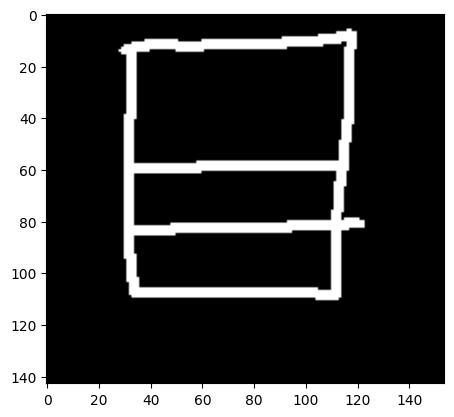

In [28]:
test_image = np.asarray(input_image)
test_image = ((1.0-test_image[:, :, 0]/255) > 0.5).astype(np.uint8)*1.0

plt.imshow(test_image, cmap="gray")
plt.show()

test_image = np.expand_dims(np.expand_dims(test_image, 0), 0)


In [26]:
test_image.shape

(1, 1, 143, 154)

In [27]:
test_image

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])

In [ ]:

# Load the ONNX model
model_path = "cnn_apl_final.onnx"
session = onnxruntime.InferenceSession(model_path)

# Run inference
inputs: list[onnxruntime.NodeArg] = session.get_inputs()
outputs: list[onnxruntime.NodeArg] = session.get_outputs()

input_name: str = inputs[0].name            # Only one input 
output_names: list[str] = [output.name for output in outputs]    # Only one output [unicode, prob] pairs for a single character

unicodes: torch.Tensor
probabilities: torch.Tensor
unicodes, probabilities = session.run(
    output_names, 
    {input_name: test_image.astype(np.float32)} # Must be float32 image of shape (batch, channels, height, width) -> (1, 1, Any, Any)
)


for char, prob in zip(unicodes[0], probabilities[0]):
    print(chr(int(char)), prob)

⌸ 0.28821778
⌹ 0.25435978
⊖ 0.15252703
@ 0.14573595
⍬ 0.058862936
⍠ 0.039472453
⍟ 0.023810962
⍙ 0.017362919
⌺ 0.015063271
Q 0.0016960067
B 0.0008566621
⍵ 0.0005646281
⊇ 0.0002887322
G 0.00023409257
⍉ 0.00022629506
8 0.0001647064
g 9.368369e-05
& 8.975658e-05
⍫ 6.020118e-05
∆ 5.0487546e-05
a 3.1156014e-05
⍝ 2.2122123e-05
⊆ 2.086064e-05
⍞ 1.8243521e-05
⍋ 1.397234e-05
⍷ 1.3026697e-05
3 1.2116537e-05
s 1.1942984e-05
∊ 1.1737614e-05
⎕ 1.1621817e-05
S 1.0351169e-05
w 9.390529e-06
e 8.838984e-06
d 5.7626726e-06
$ 4.940719e-06
⌽ 4.787412e-06
o 4.738636e-06
6 3.955339e-06
2 3.609199e-06
q 3.5381015e-06
W 3.5288078e-06
⍱ 3.1794166e-06
b 2.7211154e-06
z 2.5932843e-06
5 2.5258655e-06
⌷ 2.1485453e-06
} 1.9275826e-06
⍸ 1.720294e-06
⋄ 1.6161869e-06
E 1.3485228e-06
⍛ 1.3265477e-06
⍢ 1.3077039e-06
4 9.727377e-07
≥ 7.711606e-07
A 7.6530023e-07
0 7.27683e-07
9 7.132206e-07
H 5.872283e-07
R 5.458167e-07
→ 5.107469e-07
⍺ 4.2842666e-07
∘ 2.9059322e-07
P 2.7580458e-07
Z 2.4335517e-07
% 1.9048957e-07
≡ 1.6842

: 

In [ ]:
model_outputs

[array([ 48, 112, 100,  54, 116,  56,  53, 111, 113, 102,  98,  40, 119,
        109, 107, 106, 104, 110,  50,  99, 120, 114, 215,  51,  45,  49,
        118,  57, 103, 122, 105, 101,  41, 115, 117, 121,  55,  97,  46,
         52, 108, 247, 955,  43], dtype=int32),
 array([6.8143886e-01, 3.1727558e-01, 9.8913838e-04, 1.6000890e-04,
        5.1013758e-05, 2.8218346e-05, 2.4816827e-05, 8.7805711e-06,
        5.5376886e-06, 3.6561419e-06, 3.0133053e-06, 2.6766511e-06,
        2.4739402e-06, 1.5798223e-06, 1.5708143e-06, 8.6630882e-07,
        6.8614111e-07, 5.5757562e-07, 4.7443012e-07, 3.3036901e-07,
        6.3471326e-08, 2.9459986e-08, 2.2759442e-08, 1.8600712e-08,
        1.8000391e-08, 1.2019766e-08, 3.3489278e-09, 3.0067731e-09,
        2.6663645e-09, 2.0556845e-09, 1.1345208e-09, 3.8724163e-10,
        2.8197075e-10, 1.6642417e-10, 3.9026893e-11, 1.4455865e-11,
        1.0275350e-11, 8.5388979e-12, 2.8815811e-13, 2.1714051e-13,
        4.0094240e-14, 2.7764098e-14, 2.0496294e-15, 

In [ ]:
preds = krud_model.eval().forward(torch.tensor(test_image.astype(np.float32)))[:, 0].tolist()

[chr(int(x)) for x in preds]

TypeError: tuple indices must be integers or slices, not tuple